# EEG Microstates

In continually recorded human EEG, the spatial distribution of electric potentials across the cortex changes over time. Interestingly, for brief time periods (60 - 120ms), quasi-stable states of activity (i.e., **microstates**), characterized by unique spatial configurations of electrical activity distribution, have been observed. NeuroKit can be used to easily analyze them.

In [1]:
# Load the NeuroKit package and other useful packages
import neurokit2 as nk
import matplotlib.pyplot as plt
import mne


In [2]:
# This cell is hidden using the "hide-input" tag.
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

## EEG Preprocessing

First, let's download a raw eeg data from the [MNE](https://mne.tools/stable/index.html) package. We will crop the data for faster processing. 

In [3]:
raw = nk.data("eeg_1min_200hz")
sampling_rate = raw.info["sfreq"]

EEG recordings measure the difference in electric potential between each electrode and a reference electrode. This means that the ideal reference electrode is one which records **all** the interfering noise from the environment but doesn't pick up any fluctuating signals related to brain activity. The idea behind re-referencing is to express the voltage at the EEG scalp channels with respect to another, new reference. This "virtual reference" can be any recorded channel, or the average of all the channels, as we will use in the current analysis.

Below, we will apply a band-pass filter and re-reference the signals to remove power line noise, slow drifts and other large artifacts from the raw input.

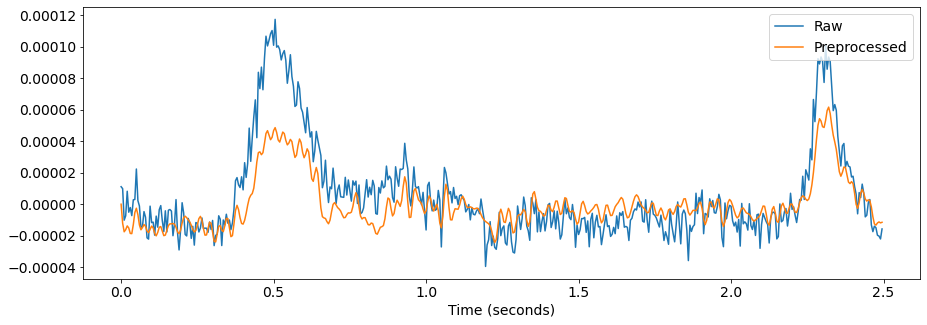

In [4]:
# Apply band-pass filter (1-35Hz) and re-reference the raw signal
eeg = raw.copy().filter(1, 35, verbose = False)
eeg = nk.eeg_rereference(eeg, 'average')

nk.signal_plot([raw.get_data()[0, 0:500], eeg.get_data()[0, 0:500]], 
               labels =["Raw", "Preprocessed"], 
               sampling_rate = eeg.info["sfreq"])

## Microstates Analysis

### Minimal Example

Microstates can be extracted and analyzed like that:

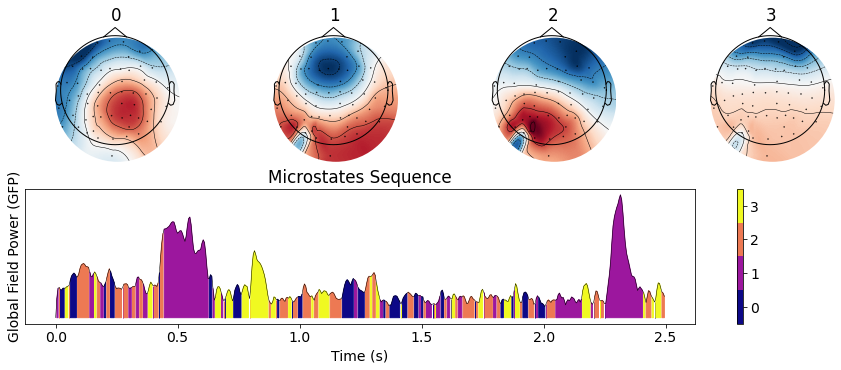

In [5]:
# Extract microstates
microstates = nk.microstates_segment(eeg, n_microstates=4)

# Visualize the extracted microstates
nk.microstates_plot(microstates, epoch = (0, 500))

This shows the aspect of the microstates and their sequence in the Global Field Power (GFP; see below). We can then proceed to a statistical analysis.

,Microstate_0_Proportion,Microstate_1_Proportion,Microstate_2_Proportion,Microstate_3_Proportion,Microstate_0_LifetimeDistribution,Microstate_1_LifetimeDistribution,Microstate_2_LifetimeDistribution,Microstate_3_LifetimeDistribution,Microstate_0_DurationMean,Microstate_0_DurationMedian,Microstate_1_DurationMean,Microstate_1_DurationMedian,Microstate_2_DurationMean,Microstate_2_DurationMedian,Microstate_3_DurationMean,Microstate_3_DurationMedian,Microstate_Average_DurationMean,Microstate_Average_DurationMedian
0,0.2645,0.178417,0.286583,0.2705,737.0,487.5,774.0,687.0,0.019075,0.015,0.018393,0.01,0.020041,0.015,0.021327,0.015,0.019782,0.015


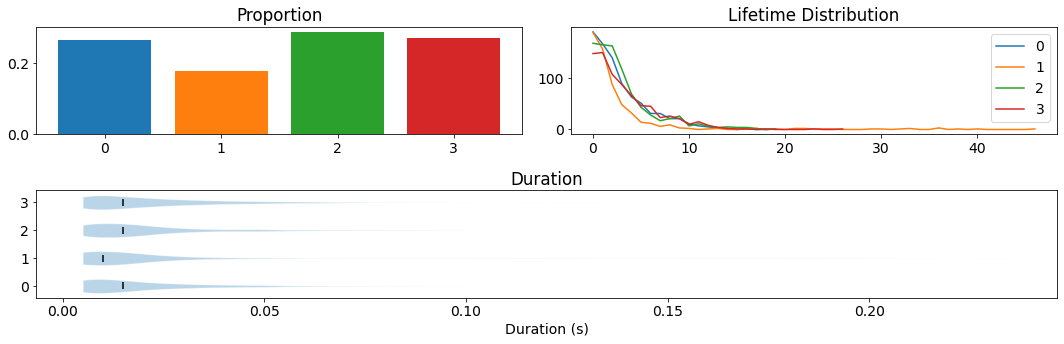

In [6]:
nk.microstates_static(microstates, sampling_rate=sampling_rate, show=True)

This shows computes static statistics, such as the prevalence of each microstates and the median duration time (also shown in the graph).

,Microstate_0_to_0,Microstate_0_to_1,Microstate_0_to_2,Microstate_0_to_3,Microstate_1_to_0,Microstate_1_to_1,Microstate_1_to_2,Microstate_1_to_3,Microstate_2_to_0,Microstate_2_to_1,Microstate_2_to_2,Microstate_2_to_3,Microstate_3_to_0,Microstate_3_to_1,Microstate_3_to_2,Microstate_3_to_3
0,0.738103,0.056098,0.112827,0.092972,0.086875,0.728164,0.099019,0.085941,0.100901,0.066589,0.750509,0.082001,0.091805,0.053913,0.088725,0.765558


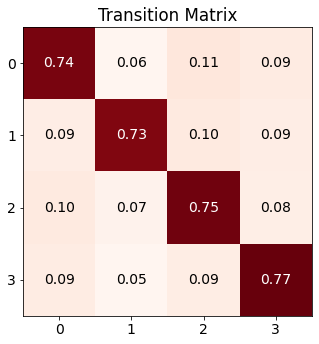

In [7]:
nk.microstates_dynamic(microstates, show=True)

Finally, one can compute complexity features of the sequence of microstates, such as the entropy.

,Microstates_Entropy_Shannon
0,1.978097


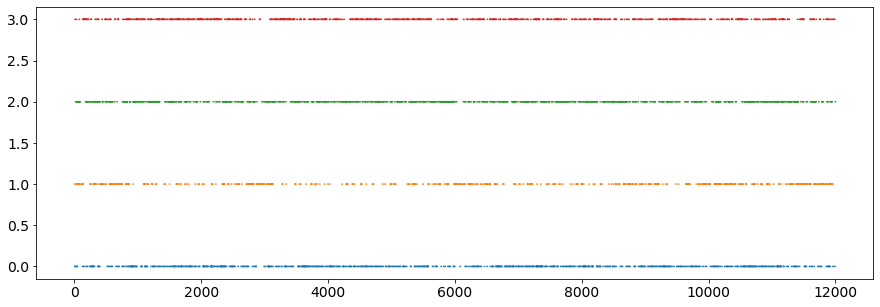

In [8]:
nk.microstates_complexity(microstates, show=True)

## Options and features

### Global Field Power (GFP)

Under the hood, `microstates_segment()` starts by computing the GFP.

The Global Field Power (GFP) is a reference-independent measure of potential field strength. It is thought to quantify the integrated electrical activity of the brain and is mathematically defined as the standard deviation of all electrodes at a given time. 

The GFP time series periodically shows peaks, where the EEG topographies are most clearly defined (i.e., signal-to-noise ratio is maximized at GFP peaks). As such, GFP peak samples are often used to extract microstates.

This can be visualized manually:



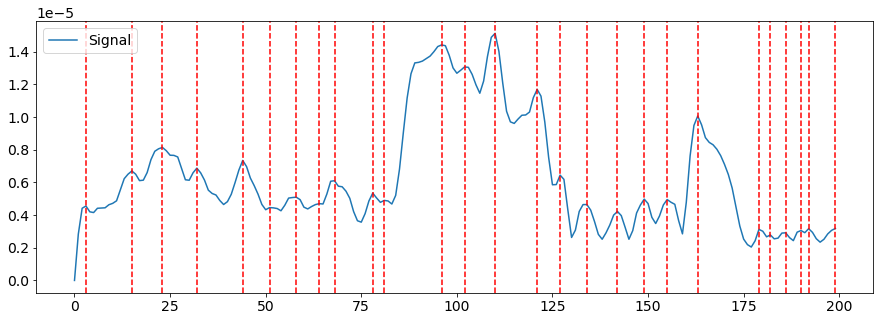

In [9]:
gfp = nk.eeg_gfp(eeg)

peaks = nk.microstates_peaks(eeg, gfp=gfp)

# Plot the peaks in the first 200 data points
nk.events_plot(events = peaks[peaks < 200], signal = gfp[0:200])

By default, the microstates clustering algorithm is **trained** on the EEG activity at these peaks, and then applied to back-predict the state at all data points. However, this behaviour can be changed. For instance, one can decide to train the algorithm directly on all data points.

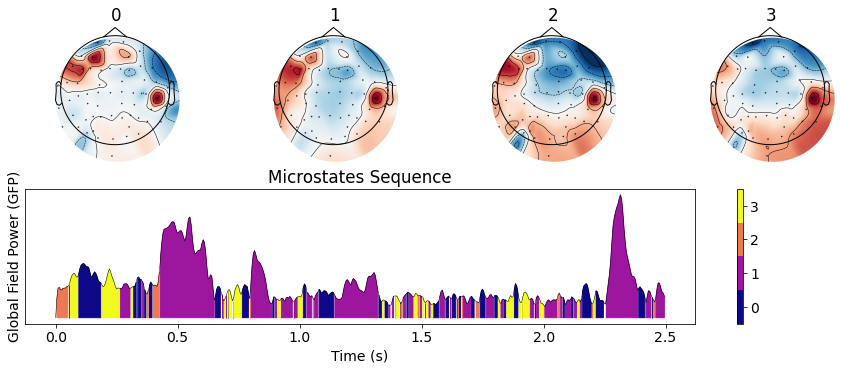

In [10]:
microstates_all = nk.microstates_segment(eeg, n_microstates=4, train="all")
nk.microstates_plot(microstates_all, epoch = (0, 500))

### How many microstates?

Most of the clustering algorithms used in microstates analysis require the number of clusters to extract to be specified beforehand. 

However, one can attempt at statistically estimating the optimal number of microstates. A variety of indices of fit can be used.

[████████████████████████████████████████] 7/7

Optimal number of microstates:  4.0


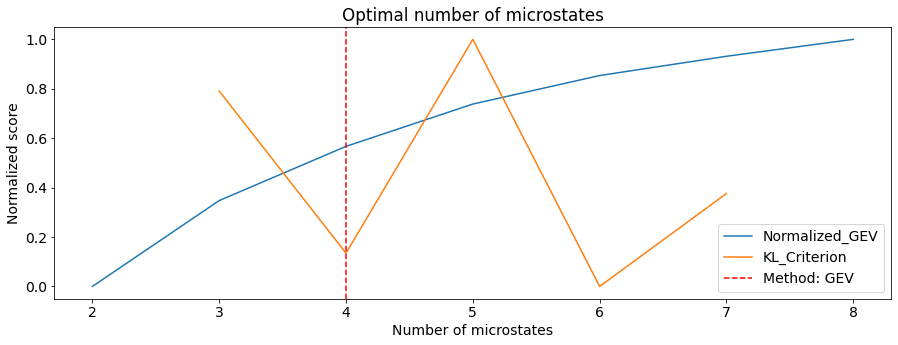

In [11]:
n_optimal, scores = nk.microstates_findnumber(eeg, n_max=8, show=True)
print("Optimal number of microstates: ", n_optimal)

### Microstates clustering algorithms

Several different clustering algorithms can be used to segment your EEG recordings into microstates. These algorithms mainly differ in how they define cluster membership and the cost functionals to be optimized ([Xu & Tian, 2015](10.1007/s40745-015-0040-1)). The method to use hence depends on your data and the underlying assumptions of the methods (e.g., some methods ignore polarity). There is no one true method that gives the best results but you can refer to [Poulsen et al., 2018](https://www.researchgate.net/publication/331367421_Microstate_EEGlab_toolbox_An_introductory_guide#pf6) if you would like a more detailed review of the different clustering methods.

In the example below, we will compare the two most commonly applied clustering algorithms - the *K-means* and *modified K-means*. Other methods that can be applied using `nk.microstates_segment` include `kmedoids, pca, ica, aahc`. 

 Using conventional Kmeans,  GEV = 51.06%
 Using modified Kmeans,  GEV = 64.05%


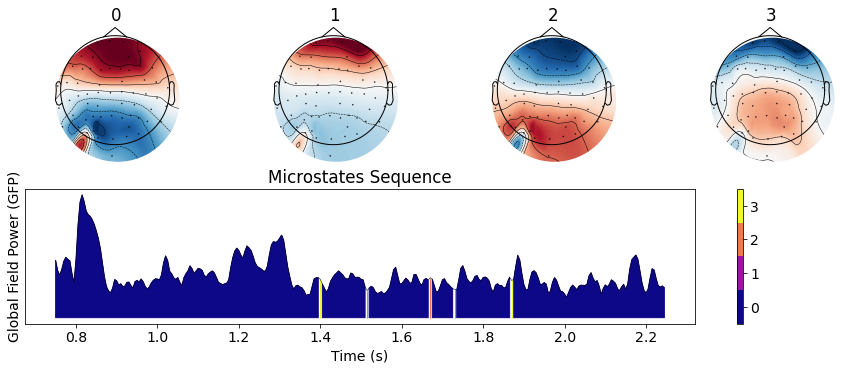

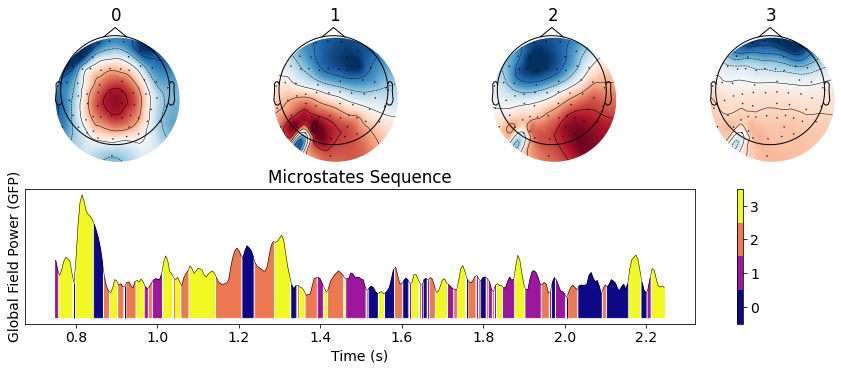

In [12]:
# Extract microstates
microstates_kmeans = nk.microstates_segment(eeg, n_microstates=4, method="kmeans")
microstates_kmod = nk.microstates_segment(eeg, n_microstates=4, method="kmod")  

# Global Explained Variance
gev_kmeans = microstates_kmeans['GEV']
gev_kmod = microstates_kmod['GEV']
print( f' Using conventional Kmeans,  GEV = {gev_kmeans*100:.2f}%')
print( f' Using modified Kmeans,  GEV = {gev_kmod*100:.2f}%')

# Visualize the extracted microstates
nk.microstates_plot(microstates_kmeans, epoch = (150, 450))
nk.microstates_plot(microstates_kmod, epoch = (150, 450))